# 🔧 Feature Engineering para Precios Inmobiliarios Dinamarca

**Objetivo**: Transformación y construcción de variables predictivas para el modelado supervisado de precios de vivienda en Dinamarca (1992-2024).

**Contenido del Notebook**:
1. **Transformación de Tipos y Columnas Derivadas** - Variables temporales, edad, precio y tamaño
2. **Codificación de Variables Categóricas** - One-hot, target y frequency encoding  
3. **Normalización y Escalado** - StandardScaler, MinMaxScaler, RobustScaler
4. **Feature Engineering Avanzado** - Interacciones, variables macro y geográficas
5. **Selección de Features** - Correlación, importancia y eliminación redundantes

In [1]:
# ==================================================
# CONFIGURACIÓN Y CARGA DE MÓDULOS
# ==================================================

# Imports principales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import pickle
import json
from datetime import datetime
from typing import Dict, List, Tuple
import sys

# Configuraciones
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Configurar ruta del proyecto
current_dir = Path.cwd()
project_root = current_dir.parent  # Sube un nivel desde notebooks/
sys.path.insert(0, str(project_root))
sys.path.insert(0, str(project_root / 'src'))

print(f"📂 Directorio actual: {current_dir}")
print(f"📁 Raíz del proyecto: {project_root}")

# Importar configuración
from config import *

# Importar funciones de feature engineering
from feature_engineering import (
    run_complete_feature_engineering_pipeline,
    create_temporal_features,
    create_price_features,
    create_size_features,
    encode_categorical_variables,
    scale_features,
    create_advanced_features,
    prepare_final_dataset,
    create_train_test_split,
    save_feature_engineering_artifacts
)

print("📊 FEATURE ENGINEERING PARA PREDICCIÓN DE PRECIOS DE VIVIENDAS")
print("=" * 60)
print(f"📅 Fecha de procesamiento: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"✅ Módulos cargados correctamente")

📂 Directorio actual: /home/exodia/Documentos/TFBigData/notebooks
📁 Raíz del proyecto: /home/exodia/Documentos/TFBigData
📊 FEATURE ENGINEERING PARA PREDICCIÓN DE PRECIOS DE VIVIENDAS
📅 Fecha de procesamiento: 2025-07-12 20:41:28
✅ Módulos cargados correctamente


In [2]:
# === CARGA DE DATOS ===
print("🔄 Cargando dataset limpio...")

# Cargar datos limpios desde análisis previo
df = pd.read_parquet(CLEAN_FILE)

print(f"✅ Dataset cargado: {df.shape[0]:,} filas x {df.shape[1]} columnas")
print(f"📅 Rango temporal: {df['date'].min()} - {df['date'].max()}")
print(f"💰 Rango de precios: {df[TARGET].min():,.0f} - {df[TARGET].max():,.0f} DKK")

# Verificar estructura del dataset
print("\n📋 Información del dataset:")
print(f"Variables categóricas: {df.select_dtypes(include=['object']).columns.tolist()}")
print(f"Variables numéricas: {df.select_dtypes(include=[np.number]).columns.tolist()}")
print(f"Variables de fecha: {df.select_dtypes(include=['datetime64']).columns.tolist()}")

# Verificar valores nulos
null_counts = df.isnull().sum()
if null_counts.sum() > 0:
    print("\n⚠️ Valores nulos encontrados:")
    print(null_counts[null_counts > 0])
else:
    print("\n✅ No hay valores nulos en el dataset")

df.head()

🔄 Cargando dataset limpio...
✅ Dataset cargado: 1,506,591 filas x 19 columnas
📅 Rango temporal: 694569600000000000 - 1727654400000000000
💰 Rango de precios: 250,010 - 46,800,000 DKK

📋 Información del dataset:
Variables categóricas: ['house_type', 'sales_type', 'address', 'city', 'area', 'region', 'dk_ann_infl_rate%', 'yield_on_mortgage_credit_bonds%']
Variables numéricas: ['date', 'quarter', 'house_id', 'year_build', 'purchase_price', '%_change_between_offer_and_purchase', 'no_rooms', 'sqm', 'sqm_price', 'zip_code', 'nom_interest_rate%']
Variables de fecha: []
✅ Dataset cargado: 1,506,591 filas x 19 columnas
📅 Rango temporal: 694569600000000000 - 1727654400000000000
💰 Rango de precios: 250,010 - 46,800,000 DKK

📋 Información del dataset:
Variables categóricas: ['house_type', 'sales_type', 'address', 'city', 'area', 'region', 'dk_ann_infl_rate%', 'yield_on_mortgage_credit_bonds%']
Variables numéricas: ['date', 'quarter', 'house_id', 'year_build', 'purchase_price', '%_change_between_off

,date,quarter,house_id,house_type,sales_type,year_build,purchase_price,%_change_between_offer_and_purchase,no_rooms,sqm,sqm_price,address,zip_code,city,area,region,nom_interest_rate%,dk_ann_infl_rate%,yield_on_mortgage_credit_bonds%
0,1727654400000000000,218,1300,Apartment,regular_sale,1971,1765000,0,3,78.0,22628.205078,"Hedekæret 38, 1. th",2640,Hedehusene,"Capital, Copenhagen",Zealand,3.35,1.1299999952316284,4.340000152587891
1,1727654400000000000,218,1307,Summerhouse,regular_sale,2009,590939,0,3,50.0,11818.780273,Violstien 11,2635,Ishøj,"Capital, Copenhagen",Zealand,3.35,1.1299999952316284,4.340000152587891
2,1727654400000000000,218,1301,Apartment,regular_sale,1940,1750000,0,2,56.0,31250.000000,"Buddingevej 72I, st. tv",2800,Kongens Lyngby,"Capital, Copenhagen",Zealand,3.35,1.1299999952316284,4.340000152587891
3,1727654400000000000,218,1302,Summerhouse,family_sale,1950,1080000,0,4,72.0,15000.000000,Frederiksvej 35,3730,Nexø,Bornholm,Bornholm,3.35,1.1299999952316284,4.340000152587891
4,1727654400000000000,218,1303,Apartment,regular_sale,1974,2300000,0,1,50.0,46000.000000,"Thyrasgade 4, 4. 508",2200,København N,"Capital, Copenhagen",Zealand,3.35,1.1299999952316284,4.340000152587891


In [3]:
# === CONVERSIÓN DE FECHAS ===
print("🔧 Convirtiendo fechas al formato correcto...")

# Las fechas están en formato timestamp (nanosegundos), convertir a datetime
df['date'] = pd.to_datetime(df['date'])

print(f"✅ Fechas convertidas correctamente")
print(f"📅 Rango temporal: {df['date'].min()} - {df['date'].max()}")

# Verificar que las fechas se ven correctas
print(f"\nPrimeras 5 fechas:")
print(df['date'].head())

🔧 Convirtiendo fechas al formato correcto...
✅ Fechas convertidas correctamente
📅 Rango temporal: 1992-01-05 00:00:00 - 2024-09-30 00:00:00

Primeras 5 fechas:
0   2024-09-30
1   2024-09-30
2   2024-09-30
3   2024-09-30
4   2024-09-30
Name: date, dtype: datetime64[ns]


## Pipeline Completo de Feature Engineering

In [4]:
# ==================================================
# EJECUTAR PIPELINE COMPLETO DE FEATURE ENGINEERING
# ==================================================

print("🚀 Ejecutando pipeline completo de feature engineering...")
print("=" * 60)

# Definir directorio de salida
output_dir = DATA_DIR / "processed"

# Ejecutar pipeline completo usando funciones modulares
results = run_complete_feature_engineering_pipeline(
    df=df,
    target_col=TARGET,
    output_dir=output_dir
)

# Extraer resultados
df_final = results['final_dataset']
selected_features = results['selected_features']
scalers = results['scalers']
metadata = results['metadata']
splits = results['splits']
saved_files = results['saved_files']
encoding_info = results['encoding_info']

print("\n🎉 Pipeline completado exitosamente!")
print(f"📊 Dataset final: {df_final.shape[0]:,} filas x {len(selected_features)} features")
print(f"📁 Archivos guardados en: {output_dir}")

# Mostrar top 10 features
print(f"\n🏆 Top 10 Features Seleccionadas:")
if 'feature_selection' in metadata and 'combined' in metadata['feature_selection']:
    for i, feature_info in enumerate(metadata['feature_selection']['combined'][:10], 1):
        print(f"{i:2d}. {feature_info['feature']:<25}: {feature_info['combined_score']:.3f}")

# Mostrar información de splits
print(f"\n📈 División Train/Test:")
split_info = splits['split_info']
print(f"Train: {split_info['train_size']:,} obs. ({split_info['train_pct']:.1f}%) - {split_info['train_period']}")
print(f"Test:  {split_info['test_size']:,} obs. ({split_info['test_pct']:.1f}%) - {split_info['test_period']}")

🚀 Ejecutando pipeline completo de feature engineering...
🚀 INICIANDO PIPELINE COMPLETO DE FEATURE ENGINEERING
📅 Creando variables temporales...
✅ Variables temporales creadas: ['year', 'month', 'quarter', 'season', 'property_age', 'decade_built', 'month_sin', 'month_cos', 'quarter_sin', 'quarter_cos']
💰 Creando variables de precio...
✅ Variables temporales creadas: ['year', 'month', 'quarter', 'season', 'property_age', 'decade_built', 'month_sin', 'month_cos', 'quarter_sin', 'quarter_cos']
💰 Creando variables de precio...
✅ Variables de precio creadas: ['log_price', 'price_per_sqm', 'price_category', 'price_zscore']
🏠 Creando variables de tamaño...
✅ Variables de tamaño creadas: ['rooms_category', 'size_category', 'sqm_per_room', 'rooms_sqm_ratio']
🔤 Iniciando codificación de variables categóricas...
✅ Variables de precio creadas: ['log_price', 'price_per_sqm', 'price_category', 'price_zscore']
🏠 Creando variables de tamaño...
✅ Variables de tamaño creadas: ['rooms_category', 'size_cat

## Análisis Paso a Paso (Opcional)

Si deseas ejecutar el proceso paso a paso para análisis detallado:

📅 Creando variables temporales...
✅ Variables temporales creadas: ['year', 'month', 'quarter', 'season', 'property_age', 'decade_built', 'month_sin', 'month_cos', 'quarter_sin', 'quarter_cos']
📅 Variables temporales creadas:
✅ year: int32
✅ month: int32
✅ quarter: int64
✅ season: object
✅ property_age: int64
✅ decade_built: int64
✅ month_sin: float64
✅ month_cos: float64
✅ quarter_sin: float64
✅ quarter_cos: float64


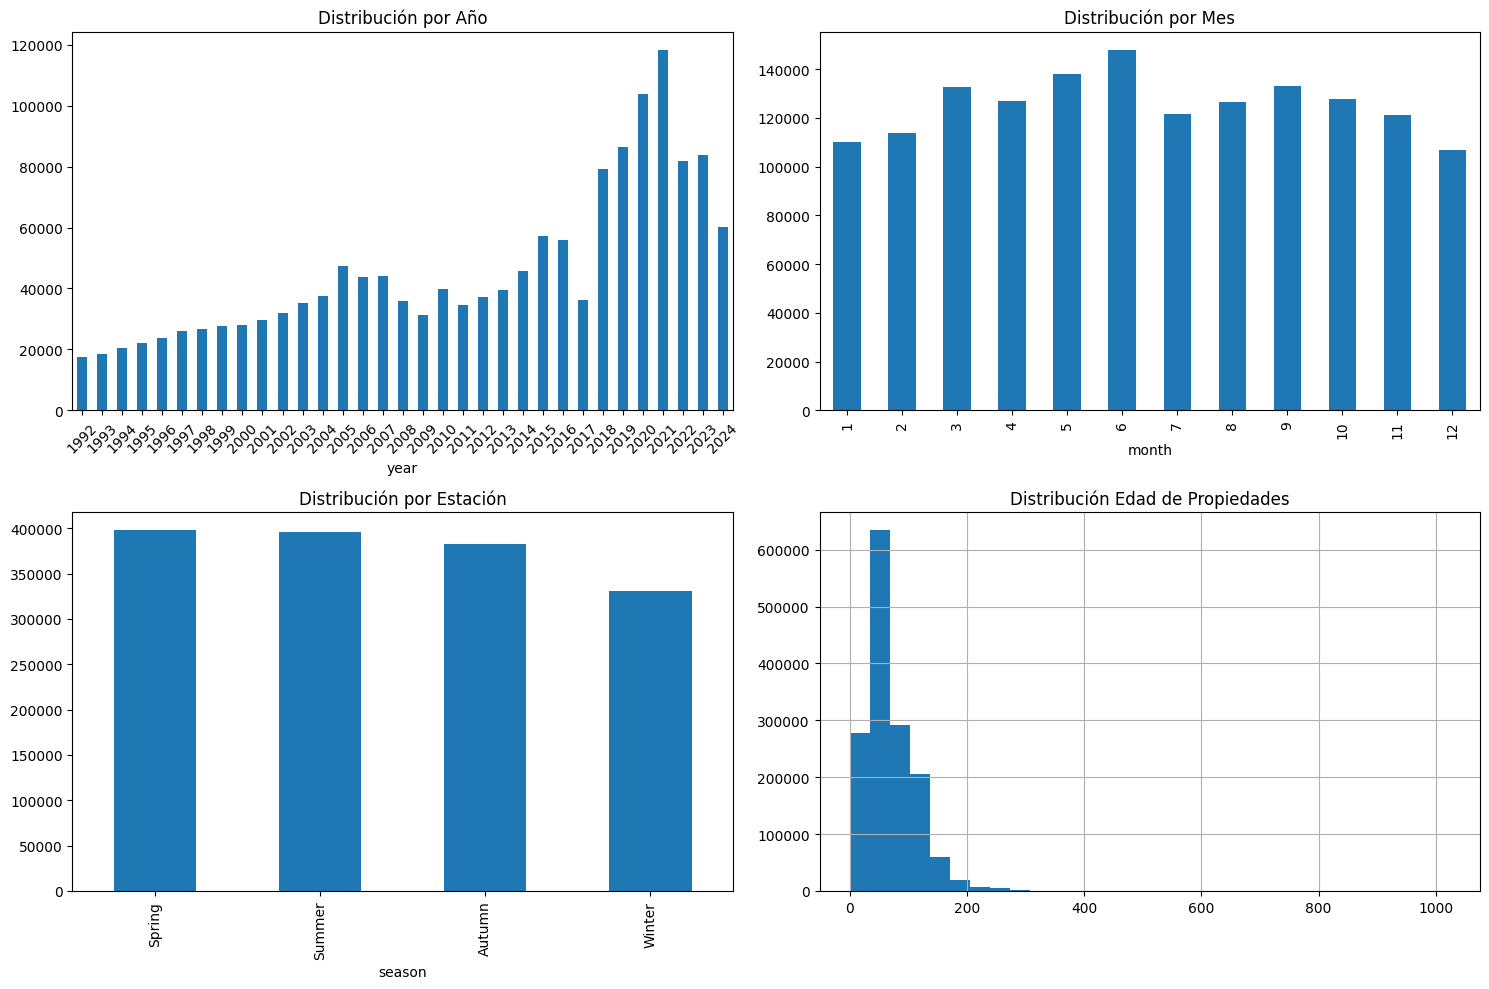


📊 Dataset con variables temporales: (1506591, 30)


In [6]:
# ==================================================
# 1. VARIABLES TEMPORALES (Paso a Paso)
# ==================================================

# Crear variables temporales
df_temporal = create_temporal_features(df, date_col='date', year_build_col='year_build')

print("📅 Variables temporales creadas:")
temporal_cols = ['year', 'month', 'quarter', 'season', 'property_age', 'decade_built',
                'month_sin', 'month_cos', 'quarter_sin', 'quarter_cos']

for col in temporal_cols:
    if col in df_temporal.columns:
        print(f"✅ {col}: {df_temporal[col].dtype}")

# Mostrar distribución de variables temporales clave
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Distribución por año
df_temporal['year'].value_counts().sort_index().plot(kind='bar', ax=axes[0,0], title='Distribución por Año')
axes[0,0].tick_params(axis='x', rotation=45)

# Distribución por mes
df_temporal['month'].value_counts().sort_index().plot(kind='bar', ax=axes[0,1], title='Distribución por Mes')

# Distribución por estación
df_temporal['season'].value_counts().plot(kind='bar', ax=axes[1,0], title='Distribución por Estación')

# Distribución de edad de propiedades - FIX: usar set_title() separadamente
df_temporal['property_age'].hist(bins=30, ax=axes[1,1])
axes[1,1].set_title('Distribución Edad de Propiedades')

plt.tight_layout()
plt.show()

print(f"\n📊 Dataset con variables temporales: {df_temporal.shape}")

🏠 Creando variables de tamaño...
✅ Variables de tamaño creadas: ['rooms_category', 'size_category', 'sqm_per_room', 'rooms_sqm_ratio']
💰 Creando variables de precio...
✅ Variables de precio creadas: ['log_price', 'price_per_sqm', 'price_category', 'price_zscore']
🔤 Iniciando codificación de variables categóricas...
✅ Variables de tamaño creadas: ['rooms_category', 'size_category', 'sqm_per_room', 'rooms_sqm_ratio']
💰 Creando variables de precio...
✅ Variables de precio creadas: ['log_price', 'price_per_sqm', 'price_category', 'price_zscore']
🔤 Iniciando codificación de variables categóricas...

📊 Análisis de cardinalidad:
region: 4 categorías únicas
house_type: 5 categorías únicas
sales_type: 5 categorías únicas
season: 4 categorías únicas
price_category: 4 categorías únicas
rooms_category: 4 categorías únicas
size_category: 3 categorías únicas

🔢 Aplicando One-Hot Encoding...

📊 Análisis de cardinalidad:
region: 4 categorías únicas
house_type: 5 categorías únicas
sales_type: 5 categor

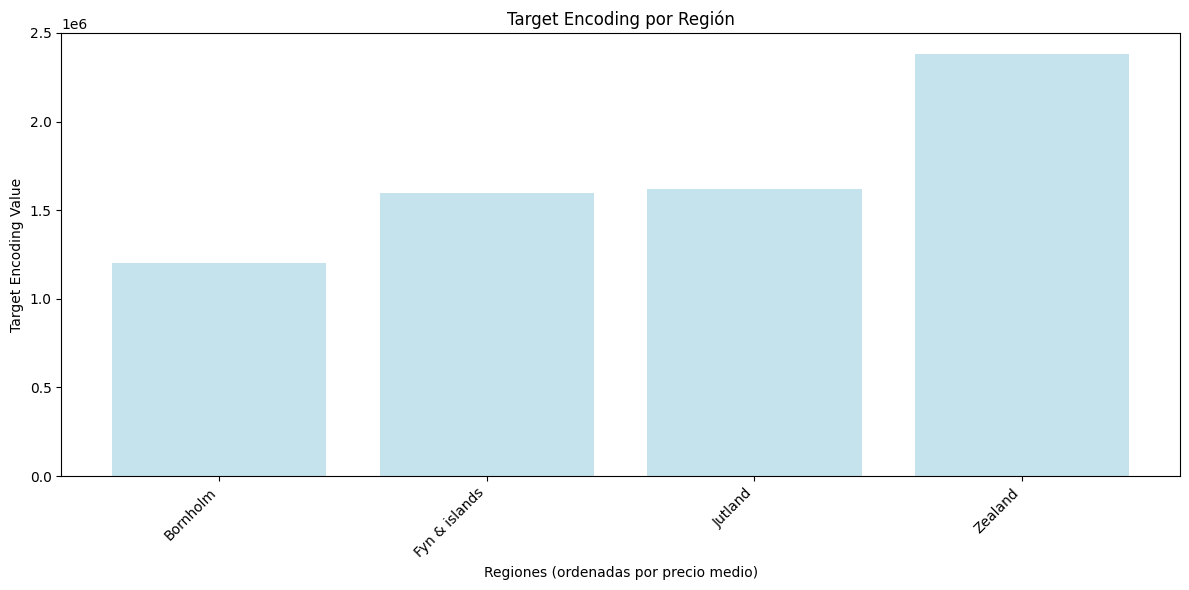

In [9]:
# ==================================================
# 2. CODIFICACIÓN CATEGÓRICA (Paso a Paso)
# ==================================================

# Crear todas las variables derivadas primero
df_with_size = create_size_features(df_temporal)
df_with_price = create_price_features(df_with_size)

# Aplicar codificación categórica
df_encoded, encoding_info = encode_categorical_variables(df_with_price, target_col=TARGET)

print("🔤 Resumen de codificación categórica:")
print(f"📊 Dataset después de encoding: {df_encoded.shape}")

# Mostrar información de cardinalidad
print("\n📋 Cardinalidad de variables categóricas:")
cardinality = encoding_info['cardinality']
for var, count in cardinality.items():
    print(f"  {var}: {count} categorías únicas")

# Mostrar variables con one-hot encoding
if 'low_card_vars' in encoding_info:
    print(f"\n🔢 Variables con One-Hot Encoding: {encoding_info['low_card_vars']}")

# Mostrar estadísticas de target encoding para region
if 'target_encoding' in encoding_info:
    print(f"\n🎯 Target Encoding para 'region':")
    target_stats = encoding_info['target_encoding']
    print(f"  Regiones procesadas: {len(target_stats)}")
    print(f"  Rango de precios medios: {target_stats['region_price_mean'].min():.0f} - {target_stats['region_price_mean'].max():.0f} DKK")

# Visualizar target encoding
if 'target_encoding' in encoding_info:
    plt.figure(figsize=(12, 6))
    target_stats = encoding_info['target_encoding'].sort_values('region_target_encoded')
    
    plt.bar(range(len(target_stats)), target_stats['region_target_encoded'], 
            color='lightblue', alpha=0.7)
    plt.xlabel('Regiones (ordenadas por precio medio)')
    plt.ylabel('Target Encoding Value')
    plt.title('Target Encoding por Región')
    plt.xticks(range(len(target_stats)), target_stats['region'], rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

📊 RESUMEN FINAL DEL FEATURE ENGINEERING
📈 Dataset Original: 1,506,591 filas x 19 columnas
🔧 Dataset Procesado: 1,506,591 filas x 30 features
🎯 Variable objetivo: purchase_price

🏆 Top 15 Features más Importantes:
 1. price_deviation_from_median   : 0.9844
 2. log_price                     : 0.5452
 3. price_per_sqm                 : 0.0901
 4. price_category_Premium        : 0.0607
 5. price_category_Medium         : 0.0429
 6. price_per_sqm_x_region        : 0.0417
 7. price_category_High           : 0.0414
 8. is_premium                    : 0.0350
 9. time_trend                    : 0.0109
10. year                          : 0.0108
11. quarter                       : 0.0104
12. phase_growth_90s              : 0.0069
13. property_age                  : 0.0045
14. phase_covid_era               : 0.0044
15. sqm                           : 0.0044

💾 Archivos Generados:
  📄 feature_engineered_complete.parquet: 46.9 MB
  📄 modeling_dataset.parquet: 46.9 MB
  📄 train_data.parquet: 28.5 MB


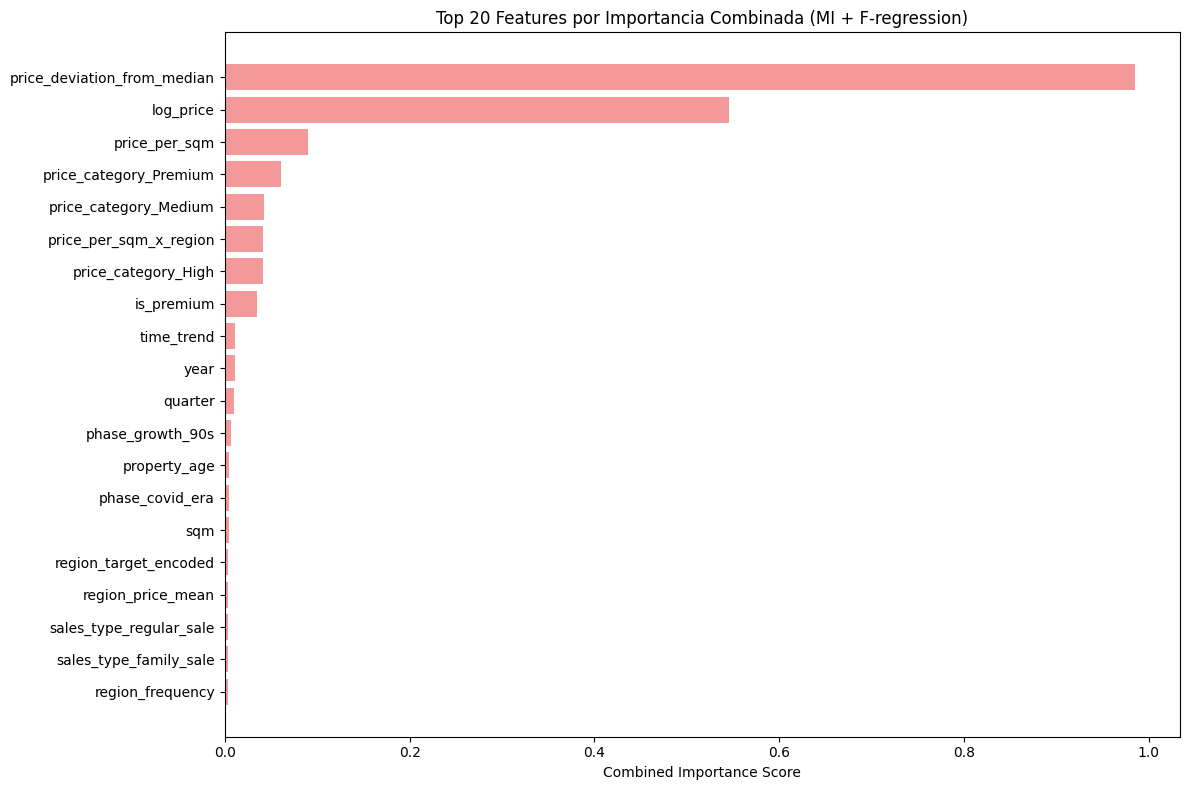


✅ Feature Engineering completado exitosamente!
📁 Los datos están listos para el modelado supervisado
🔄 Siguiente paso: 04_modelado_supervisado.ipynb


In [10]:
# ==================================================
# VISUALIZACIÓN DE RESULTADOS FINALES
# ==================================================

print("📊 RESUMEN FINAL DEL FEATURE ENGINEERING")
print("=" * 60)

# Información del dataset final
print(f"📈 Dataset Original: {df.shape[0]:,} filas x {df.shape[1]} columnas")
print(f"🔧 Dataset Procesado: {df_final.shape[0]:,} filas x {len(selected_features)} features")
print(f"🎯 Variable objetivo: {TARGET}")

# Top features
print(f"\n🏆 Top 15 Features más Importantes:")
if 'feature_selection' in metadata and 'combined' in metadata['feature_selection']:
    for i, feature_info in enumerate(metadata['feature_selection']['combined'][:15], 1):
        print(f"{i:2d}. {feature_info['feature']:<30}: {feature_info['combined_score']:.4f}")

# Información de archivos guardados
print(f"\n💾 Archivos Generados:")
for name, path in saved_files.items():
    if path.exists():
        size_mb = path.stat().st_size / (1024**2)
        print(f"  📄 {path.name}: {size_mb:.1f} MB")

# Visualización de feature importance
if 'feature_selection' in metadata and 'combined' in metadata['feature_selection']:
    top_features = metadata['feature_selection']['combined'][:20]
    
    plt.figure(figsize=(12, 8))
    features = [f['feature'] for f in top_features]
    scores = [f['combined_score'] for f in top_features]
    
    y_pos = np.arange(len(features))
    plt.barh(y_pos, scores, color='lightcoral', alpha=0.8)
    plt.yticks(y_pos, features)
    plt.xlabel('Combined Importance Score')
    plt.title('Top 20 Features por Importancia Combinada (MI + F-regression)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

print(f"\n✅ Feature Engineering completado exitosamente!")
print(f"📁 Los datos están listos para el modelado supervisado")
print(f"🔄 Siguiente paso: 04_modelado_supervisado.ipynb")

anadir enriquecimiento geografico